In [1]:
import pandas as pd
from scipy import stats
from utils import create_connection, calculate_distance
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import json
from shapely.geometry import Polygon, Point

# Load the Data Set for Seattle

In [2]:
# Connect to the database
df = pd.read_csv('./data/sea_cleaned.csv')
df.head()

,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,...,income_restrictions,latitude,longitude,zipcode,dishwasher,price/sqft,dist_seattle,dist_transit,zipcode_cluster_id,neighborhood
0,680.0,1,0.5,162.0,2022-07-02,2022-04-10,0,0,1,0,...,0,47.66035,-122.32315,98105,1.0,4.197531,3.932519,0.122959,3.0,Wallingford
1,645.0,0,1.0,148.0,2022-04-10,2022-04-10,0,0,0,1,...,0,47.59817,-122.32547,98104,0.0,4.358108,0.605872,0.075464,5.0,International District
2,645.0,0,1.0,146.0,2022-04-10,2022-04-10,0,0,0,1,...,0,47.59817,-122.32547,98104,0.0,4.417808,0.605872,0.075464,5.0,International District
3,645.0,0,1.0,115.0,2022-04-10,2022-04-10,0,0,0,1,...,0,47.59817,-122.32547,98104,0.0,5.608696,0.605872,0.075464,5.0,International District
4,900.0,0,0.0,174.0,2022-05-19,2022-04-10,0,0,0,1,...,0,47.66393,-122.30623,98105,0.0,5.172414,4.353582,0.076268,3.0,University District


# Visualization

### SQFT versus Rent

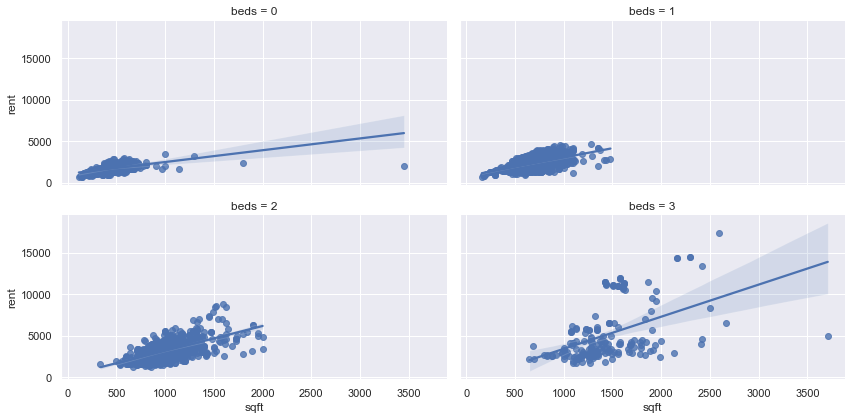

In [3]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(df[df.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'sqft','rent')

In [4]:
# Drop all studio units that have more than 1,000sqft
df.drop(df[(df.sqft>1000) & (df.beds==0)].index, inplace=True)

In [5]:
# Add a price/sqft column that will be useful for visualization
df['price/sqft'] = df.rent / df.sqft

### Transit versus Rent

In [6]:
# Visualize the relationship between price/sqft and distance to MTA stops

def transit_distance_plot(df):
 
    # Create distance bins based on distance to MTA stops
    # Look at binning for every 1/8th of a mile
    bins = np.arange(0.00, 0.3, 0.05)
    labels = bins[1:]
    df.loc[:,'transit_dist_bin'] = pd.cut(df.loc[:,"dist_transit"], bins=bins, labels=labels)
    
    # Create the boxplots
    plt.figure()
    sns.boxplot(x = 'transit_dist_bin', y = 'price/sqft', data = df)
    plt.ylim(0,10)
    plt.show()
    plt.close()
    

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


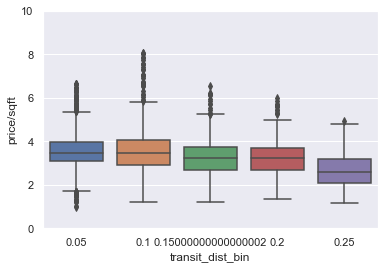

In [7]:
transit_distance_plot(df.copy())

### Plot Binary Features

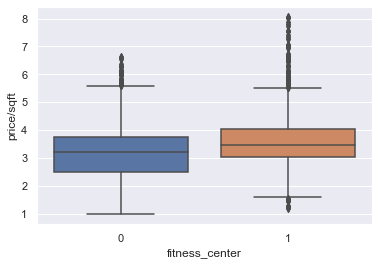

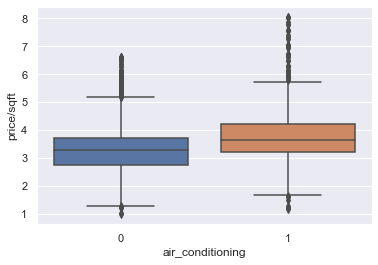

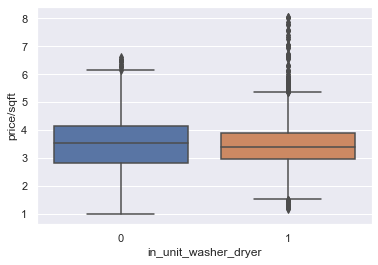

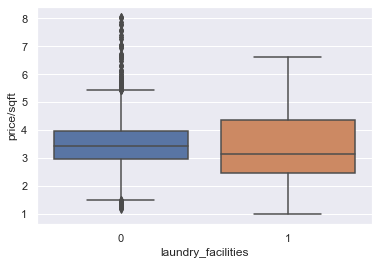

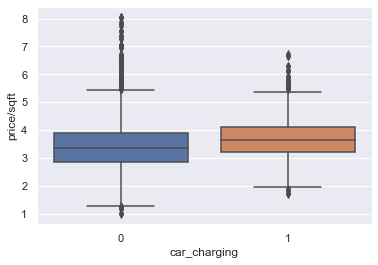

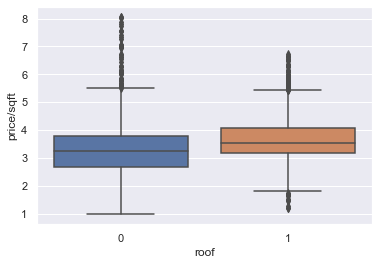

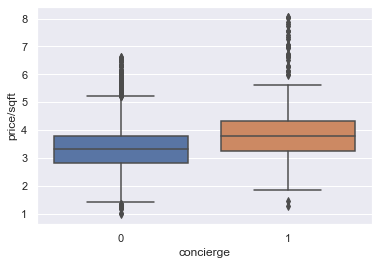

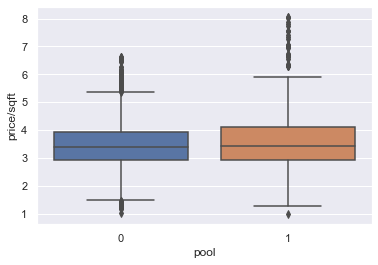

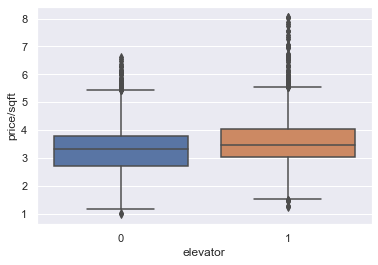

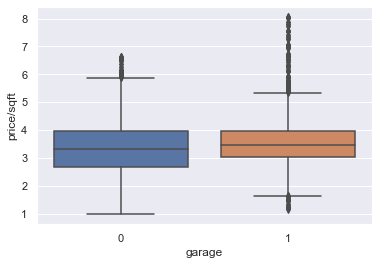

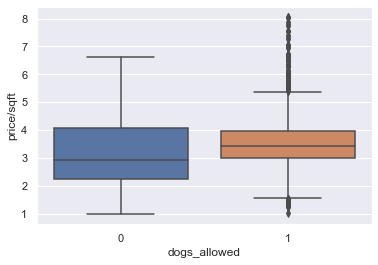

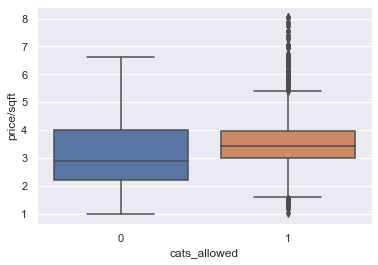

In [8]:
#plotting binary features
for i in df.columns[6:18]:
  plt.figure()
  sns.boxplot(x = i, y = 'price/sqft', data = df)
  plt.show()
  plt.close()

<AxesSubplot:>

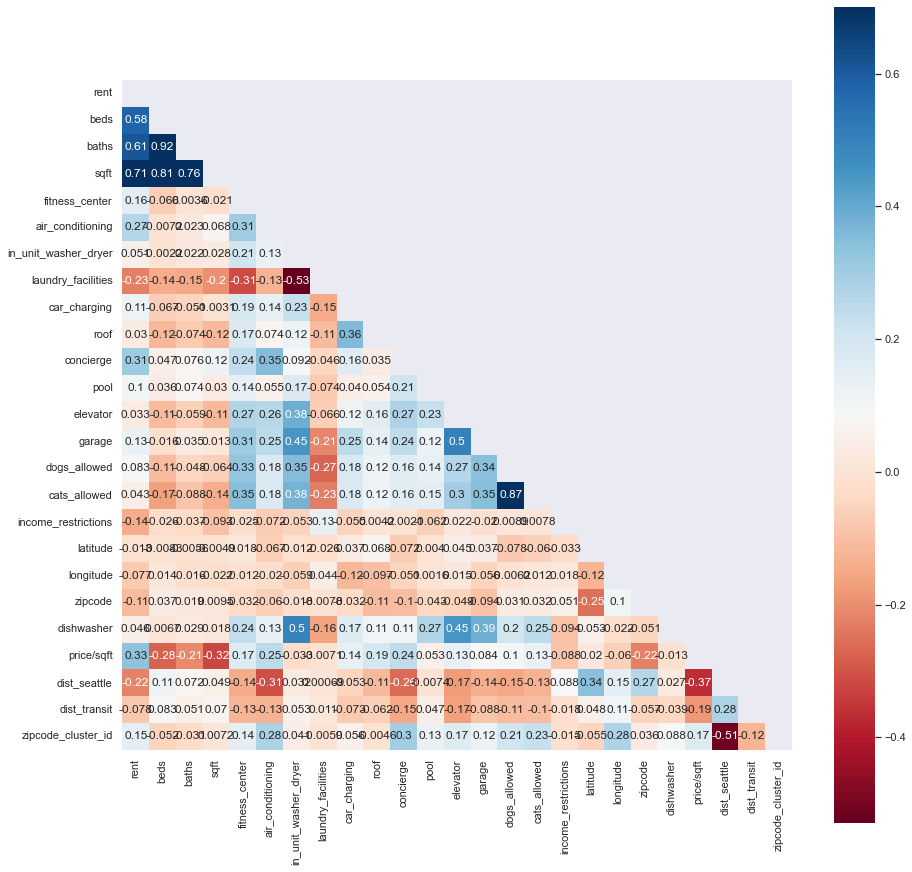

In [9]:
corr_map = df.corr()

# Create a mask
mask = np.triu(np.ones_like(corr_map, dtype=bool))

f,ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr_map, square = True, vmax = 0.7, cmap = 'RdBu', annot = True, mask = mask)

The following updates to the dataset seem necessary to consolidate similar features:
* Combine dogs and cats into a single pet category

In [10]:
# Create new pets category
df['pets_allowed']=np.where((df.dogs_allowed == 1) | (df.cats_allowed == 1),
                               1,
                               0)

# Drop columns
df.drop(columns={'dogs_allowed', 'cats_allowed'}, inplace=True)

In [11]:
# Visualize the relationship between zipcode cluster id and price/sqft

def zipcode_cluster_plot(df):
   
    # Create the boxplots
    plt.figure()
    sns.boxplot(x = 'zipcode_cluster_id', y = 'price/sqft', data = df)
    plt.ylim(0, 10)
    plt.show()
    plt.close()
    

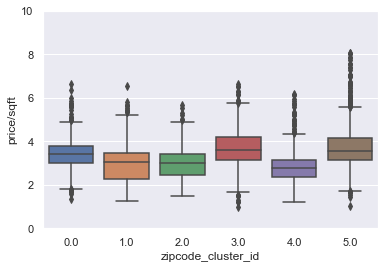

In [12]:
zipcode_cluster_plot(df.copy())

# Data processing

In [13]:
df.drop(columns={'price/sqft'}, inplace=True)
df.head()

,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,...,income_restrictions,latitude,longitude,zipcode,dishwasher,dist_seattle,dist_transit,zipcode_cluster_id,neighborhood,pets_allowed
0,680.0,1,0.5,162.0,2022-07-02,2022-04-10,0,0,1,0,...,0,47.66035,-122.32315,98105,1.0,3.932519,0.122959,3.0,Wallingford,1
1,645.0,0,1.0,148.0,2022-04-10,2022-04-10,0,0,0,1,...,0,47.59817,-122.32547,98104,0.0,0.605872,0.075464,5.0,International District,0
2,645.0,0,1.0,146.0,2022-04-10,2022-04-10,0,0,0,1,...,0,47.59817,-122.32547,98104,0.0,0.605872,0.075464,5.0,International District,0
3,645.0,0,1.0,115.0,2022-04-10,2022-04-10,0,0,0,1,...,0,47.59817,-122.32547,98104,0.0,0.605872,0.075464,5.0,International District,0
4,900.0,0,0.0,174.0,2022-05-19,2022-04-10,0,0,0,1,...,0,47.66393,-122.30623,98105,0.0,4.353582,0.076268,3.0,University District,0


In [14]:
# Get dummies for the zipcode_id column
df_model = df.join(pd.get_dummies(df.zipcode_cluster_id, prefix='zipcode_id '))
df_model.drop(columns={'zipcode_cluster_id'}, inplace=True)

df_model.head()

,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,...,dist_seattle,dist_transit,neighborhood,pets_allowed,zipcode_id _0.0,zipcode_id _1.0,zipcode_id _2.0,zipcode_id _3.0,zipcode_id _4.0,zipcode_id _5.0
0,680.0,1,0.5,162.0,2022-07-02,2022-04-10,0,0,1,0,...,3.932519,0.122959,Wallingford,1,0,0,0,1,0,0
1,645.0,0,1.0,148.0,2022-04-10,2022-04-10,0,0,0,1,...,0.605872,0.075464,International District,0,0,0,0,0,0,1
2,645.0,0,1.0,146.0,2022-04-10,2022-04-10,0,0,0,1,...,0.605872,0.075464,International District,0,0,0,0,0,0,1
3,645.0,0,1.0,115.0,2022-04-10,2022-04-10,0,0,0,1,...,0.605872,0.075464,International District,0,0,0,0,0,0,1
4,900.0,0,0.0,174.0,2022-05-19,2022-04-10,0,0,0,1,...,4.353582,0.076268,University District,0,0,0,0,1,0,0


Recall from earlier that the rent and sqft columns are not normal distributions. Both columns will need to be log transformed.

In [15]:
# Peform log transformations
df_model.rent = np.log(df_model.rent)
df_model.sqft = np.log(df_model.sqft)

In [16]:
# Save the processed data
df_model.to_csv('./data/sea_processed.csv', index=False)